# Vent Data Exploration

Before diving into Emotion Detection / Classification, it's a good idea to take a look at our data to see if there may be formatting problems, noisy data, or other similar aspects that might lower data quality and make our task harder. Onwards!

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
ROOT_PATH = str(Path('.').parent.absolute().parent)

vent = pd.read_csv('{}/data/vents.csv'.format(ROOT_PATH))

In [3]:
import re


def deitalize(string):
    return string.replace('_', '')

def reduce_whitespace(string):
    return re.sub('\s+', ' ', string)

def normalize_text(string):
    if string is None:
        return ''
    string = str(string)
    replaced_refs = string.replace('_USER_REFERENCE_', '[NAME]')
    replaced_urls = replaced_refs.replace('_URL_/', '[URL]').replace('_URL_', '[URL]')
    undo_italics = deitalize(replaced_urls)
    parse_whitespace = reduce_whitespace(undo_italics).strip()
    return parse_whitespace


In [4]:
vent.text = [normalize_text(text) for text in vent.text]

In [5]:
print('\n\n$$$$$$$$$$$$$$$$$$$$$$$\n\n'.join(vent.text[-10:].tolist()))

I'm so sorry hun you lost the love of your life. You lost your "first" babe. I'm so sorry. I was in your position 3 years back and unfortunately you survive it. I'm SO sorry... If there's anything I can do. I'm not sexier. I'm not better. But eventually you will need sex again and I'll be here. I love you. I'm not your first choice. But I'll be a choice. I just want you to know I care. If I'm a rebound I'm honored to be one.

$$$$$$$$$$$$$$$$$$$$$$$

Sex.

$$$$$$$$$$$$$$$$$$$$$$$

#nsfw // That night all I wanted to do was spread my legs and hop on it so fast and hard and I miss you. I really miss you.

$$$$$$$$$$$$$$$$$$$$$$$

I don't want to go back to work when I go home Saturday. Ugh

$$$$$$$$$$$$$$$$$$$$$$$

I miss you Cesar. Will you ever come back?? // What did I do WRONG?!?!?

$$$$$$$$$$$$$$$$$$$$$$$

I won $110!!!!!

$$$$$$$$$$$$$$$$$$$$$$$

My mom doesn't shut the fuck up.

$$$$$$$$$$$$$$$$$$$$$$$

I've been spending way too much money.

$$$$$$$$$$$$$$$$$$$$$$$

You know what

# Vent Length Analysis

Another important aspect is to choose an appropriate length for the input sequences. Let's take a look at the data.

In [6]:
import string

SEPARATOR_CHAR_SET = set(string.whitespace + string.punctuation)

def count_tokens(string):
    previous_sep = False
    separator_count = 0
    for char in string:
        if char in SEPARATOR_CHAR_SET:
            if previous_sep:
                continue
            previous_sep = True
            separator_count += 1
        else:
            previous_sep = False
    # Do not count trailing separator
    if previous_sep:
        separator_count -= 1
    return separator_count + 1


In [7]:
vent_token_counts = [count_tokens(string) for string in vent.text]

In [8]:
len(vent_token_counts)

33774613

In [9]:
np.mean(vent_token_counts)

32.25184466214313

In [10]:
percentiles = [50, 75, 80, 85, 90, 95, 99]
pct_values = np.percentile(vent_token_counts, percentiles)
pct_values

array([ 17.,  32.,  37.,  46.,  60.,  97., 298.])

In [11]:
np.std(vent_token_counts)

76.90582684608755

In [12]:
np.max(vent_token_counts)

184813

In [13]:
import matplotlib.pyplot as plt

min_token_bound = 3
max_token_bound = 45
tokens_within_bounds = [x for x in vent_token_counts if min_token_bound <= x and x <= max_token_bound]

print('Total instances within the token number bounds: {}'.format(len(tokens_within_bounds)))

plt.yscale('log')
plt.hist(tokens_within_bounds, 
         bins=np.arange(min_token_bound - 0.5, max_token_bound + 1, 1))

Total instances within the token number bounds: 27620132


(array([ 695506.,  975024., 1185143., 1279283., 1291781., 1274357.,
        1235547., 1189021., 1148001., 1113302., 1066882., 1021154.,
         974490.,  922943.,  870189.,  847318.,  769047.,  732609.,
         679516.,  638134.,  600429.,  567179.,  532319.,  501058.,
         470967.,  442445.,  415002.,  391176.,  366365.,  345167.,
         323883.,  305898.,  289893.,  272980.,  258293.,  243802.,
         231122.,  219786.,  207024.,  196075.,  186286.,  175860.,
         167876.]),
 array([ 2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5, 12.5,
        13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5,
        24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5,
        35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5, 44.5, 45.5]),
 <a list of 43 Patch objects>)

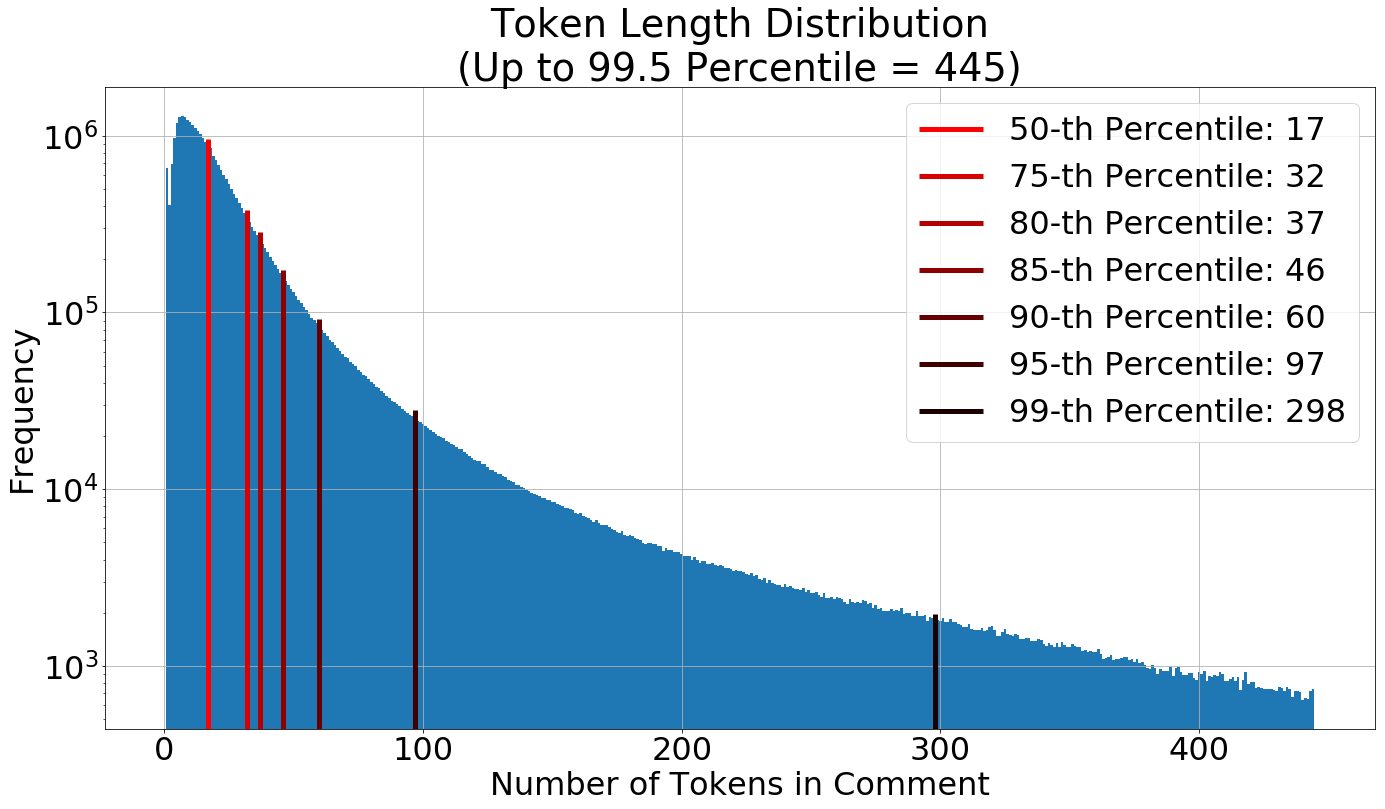

In [22]:
import matplotlib

threshold = int(np.percentile(vent_token_counts, 99.5))

plt.figure(figsize=(20, 12))
matplotlib.rcParams.update({'font.size': 32})

plt.yscale('log')
plt.title(f'Token Length Distribution\n(Up to 99.5 Percentile = {threshold})')
plt.ylabel('Frequency')
plt.xlabel('Number of Tokens in Comment')
bins, _, _ = plt.hist([x for x in vent_token_counts if x < threshold], bins=np.arange(-0.5, threshold + 1, 1))
bin_heights = bins[pct_values.astype('int')]
colors = [(c, 0, 0) for c in [1.0, 0.85, 0.7, 0.55, 0.4, 0.25, 0.1]]
for value, height, pct, color in zip(pct_values, bin_heights, percentiles, colors):
    value = int(value)
    plt.vlines(value, ymin=0, ymax=height*1.1, linewidths=5, color=color, label=f'{pct}-th Percentile: {value}')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('../output/VentTokenLengthDistribution.pdf')

In [15]:
vent_preprocessed = pd.read_parquet('{}/preprocessed/vent.parquet'.format(ROOT_PATH))

In [16]:
emo_counts = vent_preprocessed.groupby(['emotion_categories_label', 'emotions_label']).size()

In [17]:
emo_counts_frame = emo_counts.reset_index()
emo_counts_frame.columns = ['category', 'emotion', 'count'] 

category_counts = emo_counts_frame.groupby(['category'])['count'].sum().reset_index()
category_counts.columns = ['category', 'category_count'] 

all_counts = emo_counts_frame.merge(category_counts, on='category', how='inner').sort_values(['category_count', 'count'], ascending=False)
all_counts

,category,emotion,count,category_count
81,7,74,1018982,4683649
77,7,53,697677,4683649
79,7,57,504807,4683649
73,7,27,431081,4683649
74,7,32,400219,4683649
...,...,...,...,...
62,6,19,88944,888331
66,6,58,69832,888331
70,6,84,66120,888331
69,6,75,48008,888331


In [18]:
emo_df = pd.read_csv('{}/data/emotions_clean.csv'.format(ROOT_PATH))
cat_df = pd.read_csv('{}/data/emotion_categories_clean.csv'.format(ROOT_PATH))

emo_indices = {i: str(n) for i, n in enumerate(emo_df.name.sort_values().tolist())}
cat_indices = {i: str(n) for i, n in enumerate(cat_df.name.sort_values().tolist())}

all_counts.emotion = [emo_indices[emo] for emo in all_counts.emotion.tolist()]
all_counts.category = [cat_indices[cat] for cat in all_counts.category.tolist()]

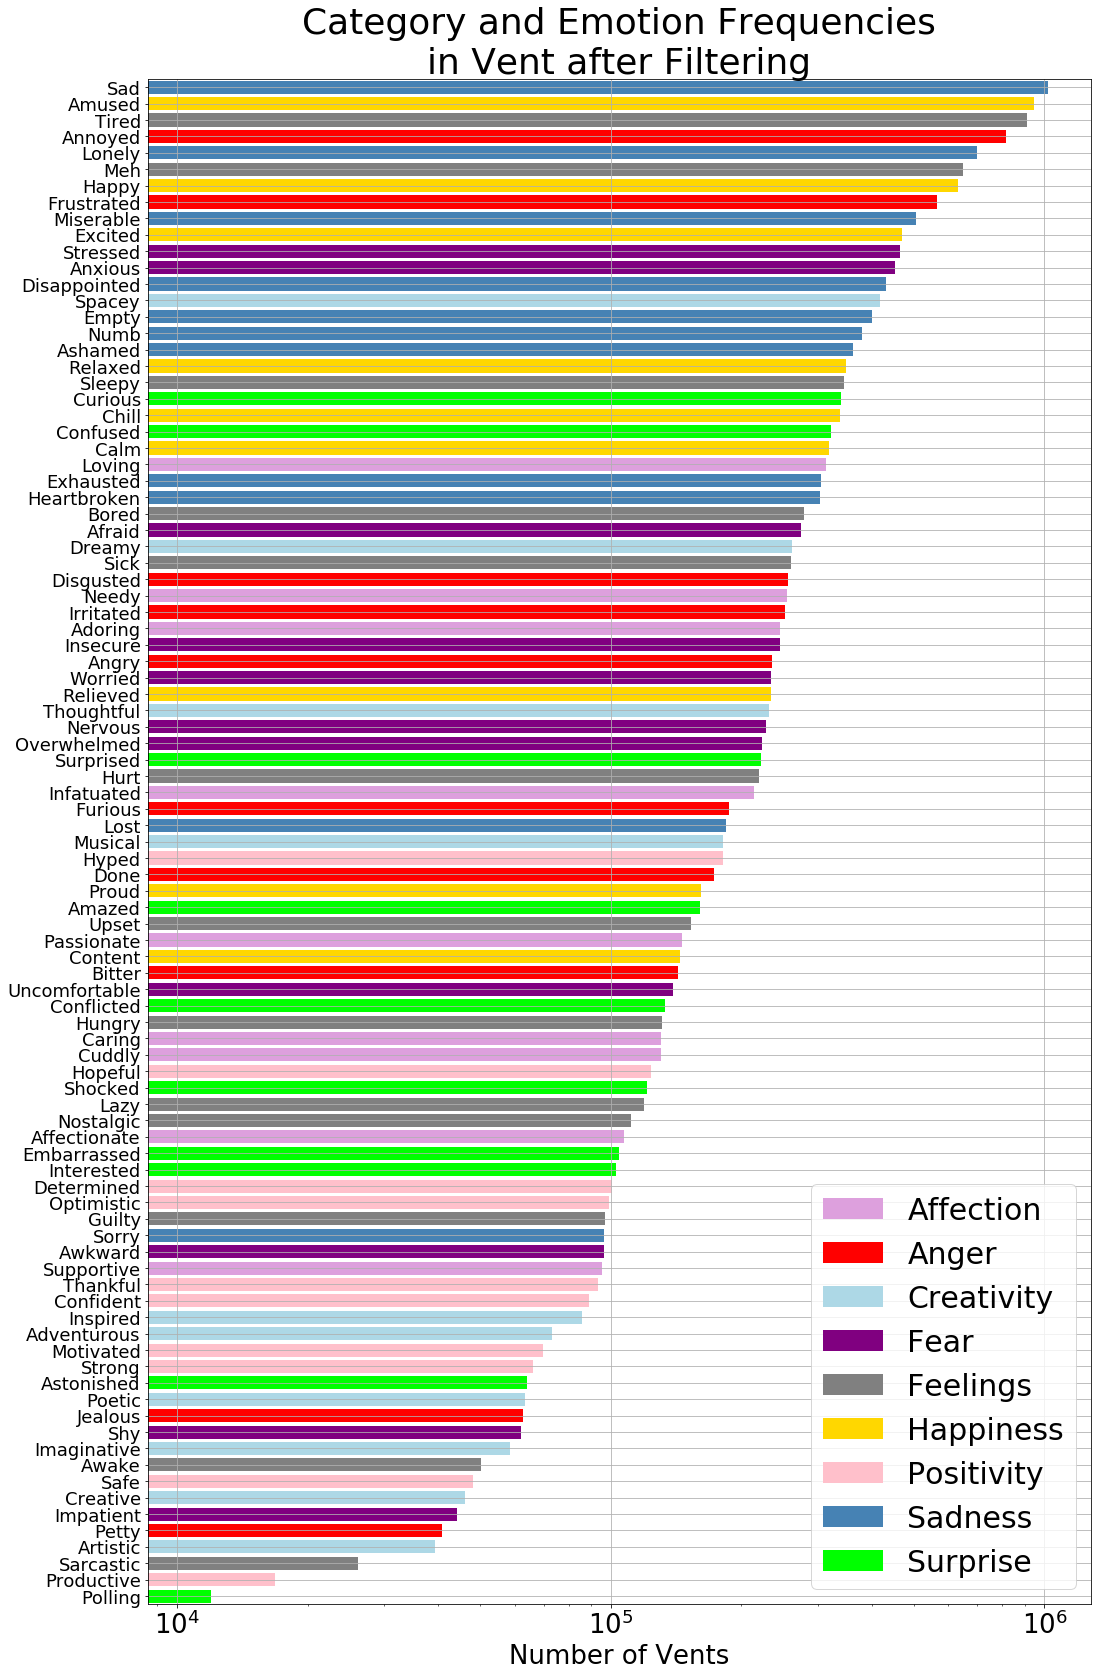

In [24]:
import matplotlib.patches as mpatches


by_count = all_counts.sort_values('count', ascending=True)

num_emos = len(emo_df)

# Prepare the data
y_pos = np.arange(0.5, num_emos, 1.0) 
categories = by_count.category.tolist()
category_set = sorted(set(categories))
num_cats = len(category_set)
color_list = ['plum', 'red', 'lightblue', 'purple', 'grey', 'gold', 'pink', 'steelblue', 'lime']
color_map = {cat: col for cat, col in zip(category_set, color_list)}
colors = [color_map[cat] for cat in categories]
all_hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
hatch_map = {cat: all_hatches[i] for i, cat in enumerate(category_set)}
hatches = [hatch_map[cat] for cat in categories]

# Set the environment
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(16, 24))
plt.xscale('log')
plt.ylim(0, num_emos)
plt.yticks(y_pos, by_count.emotion.tolist())


# Plot each line with hatches
for category in category_set:
    y, c, cat, col, hat = zip(*[t for t in zip(y_pos, by_count['count'].tolist(), categories, colors, hatches) if t[2] == category])
    col = col[0]
    hat = hat[0]
    plt.barh(y, c, label=cat, color=col)# , hatch=hat)

matplotlib.rcParams.update({'font.size': 30})
plt.xlabel('Number of Vents', fontsize=26)
plt.xticks(fontsize=26)
plt.title('Category and Emotion Frequencies\nin Vent after Filtering')
plt.legend(handles=[mpatches.Patch(facecolor=color_map[cat], label=cat) for cat in category_set]) #  hatch=hatch_map[cat]
plt.grid()
plt.tight_layout()
plt.savefig('../output/VentEmotionAndCategoryFrequencies.pdf')